# TP1 Deep QLearning

Dans ce TP, l'objectif est d'implémenter un agent apprenant à faire atterir un vaisseau sur la lune avec l'algorithme Deep Q-Network. Pour cela vous allez utiliser [PyTorch](https://pytorch.org/) et [Gymnasium](https://gymnasium.farama.org/). 

<img src='img/lunarlander.png'  width=500px>

# 1. Consignes

> <span style="color:red">Compléter ce notebook et les différents fichiers python associés</span>.  
> 
>  <span style="color:red">Répondre aux questions</span> (dans les cellules <span style="color:blue">Votre réponse: </span> )


> Le code doit être fonctionnel avec l'environnement virtuel du TP. Si d'autres packages que ceux présents dans l'environnement virtuel créé au départ sont nécessaires, vous devez ajouter à votre dépôt un fichier `environnement.yaml` qui est un export de votre environnement virtuel. Ce fichier est obtenu avec la commande suivante:  ```conda env export > environnement.yaml```



# 2. Import des packages

In [2]:
import gymnasium as gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
def init_seed(seedval):
    torch.manual_seed(seedval)
    np.random.seed(seedval)
    random.seed(seedval)

# 3. Gymnasium

En apprentissage par renforcement, il y a deux concepts fondamentaux : l’agent et l’environnement.
- L’agent est l’entité apprenante qui observe l’environnement et agit sur celui-ci selon les actions disponibles. Son objectif est de maximiser la récompense cumulée qu’il recoit de l’environnement avec lequel il interagit.
- L'agent interagit avec l'environnement à travers la boucle de perception/action ce qui nécessite de définir :
    - Un espace d’action.
    - Un espace d’état (ou observation).
    - Une fonction de récompense.
  
[Gymnasium](https://gymnasium.farama.org/) propose une interface open source unifiée entre un agent et un environnement.
- [Gymnasium](https://gymnasium.farama.org/) propose un ensemble d'environnements pour des tâches d'apprentissage par renforcement. La plupart des environnements ont leur code source disponible sur [GitHub](https://github.com/Farama-Foundation/Gymnasium/tree/main/gymnasium/envs). De nouveaux environnements peuvent aussi être créés à condition qu'ils soient compatibles avec l'interface. 
- Grâce à l'interface unifiée, il est possible de définir indépendamment un agent de l’environnement avec lequel il interagit (et inversement). 
- Lorsque certains pré-traitements sont nécessaires sur les actions, observations, récompenses, ... il est possible d’encapsuler l’environnement dans un **wrapper**, celui-ci se chargera du pré-traitement. 




>  <span style="color:green">Documentation de Gymnasium</span>: [utilisation basique](https://gymnasium.farama.org/content/basic_usage/), [API pour les environnements](https://gymnasium.farama.org/api/env/), ...




##  3.1 - Caractéristiques de l'environnement LunarLander

Dans ce TP, nous allons implémenter un agent qui interagira avec l'environnement **LunarLander**, présenté  [ici](https://gymnasium.farama.org/environments/box2d/lunar_lander/) et le code source est [ici](https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py). 2 versions de LunarLander existent: avec des actions discrètes ou des actions continues.

> <span style="color:green">Quelle version choisir pour utiliser le DQN ? Pourquoi ? 



> <span style="color:blue">Votre réponse: </span>

Il faut choisir la version avec des actions discrètes, c'est-à-dire la version qui comprend un nombre d'action limité et défini. Le DQN fonctionne avec des actions discrètes, car il utilise une table Q pour stocker les valeurs d'action-état. Si les actions étaient continues, il y aurait une infinité d'actions possibles, rendant la table Q impossible à gérer.

Il existe plusieurs fonctions clés pour interagir avec un environnement Gymnasium ( [utilisation basique](https://gymnasium.farama.org/introduction/basic_usage/) et [API](https://gymnasium.farama.org/api/env/)).


> <span style="color:green">Compléter la cellule de code ci-dessous pour afficher:
> 
> - **les dimensions pour les espaces d'états et d'actions** de l'environnement `LunarLander`.
> - les bornes min et max pour les dimensions de l'état
> - un échantillon pris au hasard dans chaque espace. 

In [3]:
env = gym.make("LunarLander-v3")

# Dimension de l'état et du nombre d'actions
print("Dimension état :", env.observation_space.shape[0])
print("Dimension action :", env.action_space.n)

# Bornes min et max de l'état
print("Bornes état :")
print("Min : ", env.observation_space.low)
print("Max : ", env.observation_space.high)

# Echantillon 
print(f"Échantillon aléatoire de l'espace d'état : {env.observation_space.sample()}")
print(f"Échantillon aléatoire de l'espace d'action : {env.action_space.sample()}")





Dimension état : 8
Dimension action : 4
Bornes état :
Min :  [ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ]
Max :  [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ]
Échantillon aléatoire de l'espace d'état : [ 0.16482167 -1.2117152  -0.3748717   7.124034   -4.5266447   1.3091519
  0.12405944  0.18079129]
Échantillon aléatoire de l'espace d'action : 2


> <span style="color:green"> </span>  A quoi correspond dans le cas du LunarLander une terminaison d'un épisode avec *terminated* à True ? avec *truncated* à True ?

> <span style="color:blue">Votre réponse: </span>

Terminated signifie que lors de l'épisode, l'agent a atteint un état terminal, comme atterrir avec succès ou s'écraser.
Truncated signifie que l'épisode a été interrompu avant même d'avoir atteint un état terminal, une limite de temps par exemple.

```python

## 3.2 Interaction et affichage de l'environnement sur un épisode

> <span style="color:green">Exécuter une instance de l'environnement `LunarLander` pendant un épisode avec des **actions aléatoires**. Afficher l'environnement à chaque pas pour visualiser le comportement du vaisseau. A la fin de l'épisode, afficher la somme des récompenses obtenues sur l'épisode et la raison pour laquelle l'épisode s'est terminé. </span>



In [4]:
env = gym.make("LunarLander-v3", render_mode="human")

obs, info = env.reset()
terminated = False 
truncated = False
sum_reward = 0
env.render()

while not terminated and not truncated:
    action = env.action_space.sample() # on choisit une action aléatoire
    obs, reward, terminated, truncated, info = env.step(action)
    sum_reward += reward
    env.render() # on affiche l'environnement

print(f"Récompenses obtenues : {sum_reward}")
if terminated :
    print("L'épisode s'est terminé naturellement (atterrissage ou crash)")
elif truncated :
    print("L'épisode a été tronqué (par exemple, limite de temps atteinte)")

env.close()


Récompenses obtenues : -236.98846267294397
L'épisode s'est terminé naturellement (atterrissage ou crash)


# 4. Agent simple (sans apprentissage)

Vous devez maintenant implémenter un **agent simple** qui utilise une **Q fonction paramétrée** (réseau de neurones) pour choisir ses actions selon une stratégie $\epsilon$-greedy (mais pas d'apprentissage pour l'instant).

> <span style="color:green">- Quels éléments seront en entrée du NN ? En sortie ? Quelle sera la dimension de l'entrée ? De la sortie ? </span>



> <span style="color:blue">Votre réponse: </span>

L'entrée du réseau de neurones contient l'état actuel de l'environnement : - la position (en x et y) - la vitesse (en x et y) - l'angle - la vitesse angulaire - les indicateurs de contact avec le sol (gauche et droite). La dimension de l'entrée est donc 8.

La sortie du réseau de neurones contient les actions possibles : - ne rien faire - allumer le moteur principal - allumer le moteur gauche - allumer le moteur droit. La dimension de la sortie est donc 4.



> <span style="color:green">- Quelle fonction d'activation sera utilisée sur le dernière couche du réseau ? Pourquoi ? </span>


> <span style="color:blue">Votre réponse: </span>

Les valeurs de sortie sont des valeurs de Q, or celles-ci peuvent être positives ou négatives et n'ont pas de borne supérieure. On ne peut donc pas utiliser une fonction d'activation non linéaire comme ReLU ou Sigmoid car elles limiteraient la plage de valeurs possibles. On utilisera donc aucune fonction d'activation sur la dernière couche. 

- définir l'architecture du réseau de neurones en complétant `QNN.py`. Ce réseau va approximer la Q-fonction comme dans DQN (pour l'instant, les poids du réseau ne seront pas mis à jour, le réseau est uniquement utilisé en prédiction).

- définir un agent simple en complétant `agentsimple.py`: il utilisera la prédiction du réseau de neurones pour choisir ses actions selon une stratégie d’exploration $\epsilon$-greedy.

- utiliser cet agent sur plusieurs épisodes dans `LunarLander`. Vous utiliserez une décroissance de l'exploration, i.e. que $\epsilon$ va décroitre à chaque épisode, en démarrant à une valeur élevée (beaucoup d'exploration) et avec une borne minimum. Ainsi, au premier épisode, $\epsilon=\epsilon_{start}$, et à chaque épisode, $\epsilon=max(\epsilon_{end}, \epsilon_{decay}*\epsilon)$. Par exemple sur 1000 épisodes, les valeurs peuvent être $\epsilon_{start} = 1.0$, $\epsilon_{end} = 0.01$ et $\epsilon_{decay} = 0.995$.

- proposer un tracé de la somme des récompenses obtenues par épisode (vous pouvez utiliser le fichier `utils.py`, le wrapper [RecordEpisodeStatistics](https://gymnasium.farama.org/api/wrappers/misc_wrappers/#gymnasium.wrappers.RecordEpisodeStatistics ),  ...).


In [5]:
#Reload all modules every time before executing the Python code typed
%autoreload 2
# import depuis un fichier python local 
from QNN import QNN 
from agentsimple import AgentSimple
import utils

Épisode 100/1000, Récompense: -491.41, Epsilon: 0.6058
Épisode 200/1000, Récompense: -357.34, Epsilon: 0.3670
Épisode 300/1000, Récompense: -473.87, Epsilon: 0.2223
Épisode 400/1000, Récompense: -369.61, Epsilon: 0.1347
Épisode 500/1000, Récompense: -688.59, Epsilon: 0.0816
Épisode 600/1000, Récompense: -512.36, Epsilon: 0.0494
Épisode 700/1000, Récompense: -641.66, Epsilon: 0.0299
Épisode 800/1000, Récompense: -485.41, Epsilon: 0.0181
Épisode 900/1000, Récompense: -476.79, Epsilon: 0.0110
Épisode 1000/1000, Récompense: -423.31, Epsilon: 0.0100


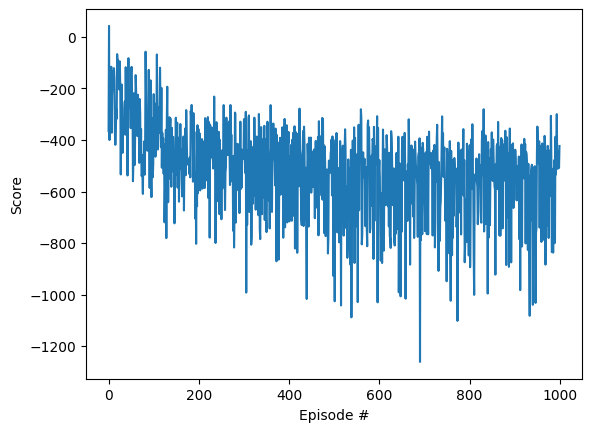

Moyenne des récompenses sur les 100 derniers épisodes: -579.57


In [6]:
#TODO
# Hyperparamètres
NB_EPISODES = 1000
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995 

env = gym.make("LunarLander-v3")

dim_entree = env.observation_space.shape[0] # 8
dim_sortie = env.action_space.n # 4

agent = AgentSimple(dim_entree, dim_sortie)

rewards_list = [] # liste des récompenses par épisode
epsilon = EPS_START

for episode in range(NB_EPISODES):
    obs, info = env.reset()
    terminated = False
    truncated = False
    episode_reward = 0

    while not terminated and not truncated:
        action = agent.action_egreedy(obs, epsilon)
        obs, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        
    rewards_list.append(episode_reward) 

    epsilon = max(EPS_END, EPS_DECAY * epsilon)
    
    if (episode + 1) % 100 == 0:
        print(f"Épisode {episode + 1}/{NB_EPISODES}, Récompense: {episode_reward:.2f}, Epsilon: {epsilon:.4f}")

env.close()

utils.plot_sumrwdperepi(rewards_list)

mean_last_100_episodes = np.mean(rewards_list[-100:])
print(f"Moyenne des récompenses sur les 100 derniers épisodes: {mean_last_100_episodes:.2f}")

# 5. Deep QLearning avec Replay Buffer

L'algorithme (sans réseau cible) est donné ci-dessous:

<img src='img/DQN2.png'  width=700px>


- La phase d'**échantillonage** est une phase d'interaction avec l'environnement (sans apprentissage), pendant laquelle l'agent stocke en mémoire toutes les transitions rencontrées. Une transition est un tuple `(état,action,état_suivant,récompense,fin_episode)`. La mémoire a une taille maximale; lorsqu’elle est dépassée, les nouvelles transitions remplacent les plus anciennes. 

- La phase d'**apprentissage** permet de mettre à jour les paramètres de la fonction *Q* à partir de plusieurs (minibatch) transitions (64 par exemple) stockées dans la mémoire. La phase d'apprentissage est réalisée tous les `t` pas (ou actions) dans l'environnement (par ex. $t=4$).

- La classe `ReplayBuffer` du fichier `replaybuffer.py` permet de stocker des transitions dans une mémoire et de récupérer des minibatch de transitions.


Vous devez implémenter l'algorithme du **Deep QLearning avec ReplayBuffer** donné ci-dessus.

Remarque: 
- vous n'utiliserez pas de réseau cible (*target network*) pour l'instant.
- Pour l'optimizer, SGD et [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) sont particulièrement adaptés. 
- Dans la phase d'apprentissage, les éléments récupérés dans un minibatch  sont des tenseurs de taille $d \times dim\_element$. Vous devez dans cette phase faire des calculs tensoriel directement (et pas de boucle for sur $d$ !)
- Voici aussi des liens vers différentes fonctions de PyTorch qui pourraient vous être utiles: [unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html), [gather](https://pytorch.org/docs/stable/generated/torch.gather.html)


> <span style="color:green">Compléter la classe `AgentDQN`</span> 
>
> <span style="color:green">Implémenter l'algorithme dans la fonction *dqnalgo* ci-dessous.  </span> 
>
> <span style="color:green">Utiliser cet agent sur plusieurs épisodes dans l'environnement `LunarLander`. Vous proposerez un tracé de la somme des récompenses obtenues par épisode (vous pouvez utiliser `utils.py`).</span> 


 
 

In [7]:
#Reload all modules every time before executing the Python code typed
%autoreload 2
from replaybuffer import ReplayBuffer
from agentdqn import AgentDQN

In [8]:
#TODO

def dqnalgo(agent, env, nb_episodes, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """
    Algorithme d'entraînement Deep Q-Learning.

    Args:
        agent (AgentDQN): L'agent à entraîner.
        env: L'environnement Gymnasium.
        nb_episodes (int): Le nombre d'épisodes pour l'entraînement.
        eps_start (float): Valeur initiale d'epsilon.
        eps_end (float): Valeur minimale d'epsilon.
        eps_decay (float): Facteur de décroissance d'epsilon.

    Returns:
        list: Une liste contenant la somme des récompenses pour chaque épisode.
    """
    rewards_list = []  # Pour stocker la récompense de chaque épisode
    epsilon = eps_start

    for episode in range(1, nb_episodes + 1):
        obs, info = env.reset()
        episode_reward = 0
        terminated = False
        truncated = False

        while not terminated and not truncated:
            # 1. Choisir une action
            action = agent.action_egreedy(obs, epsilon)

            # 2. Effectuer l'action dans l'environnement
            next_obs, reward, terminated, truncated, info = env.step(action)

            # 3. L'agent mémorise la transition et apprend si nécessaire
            #    Le booléen "done" est True si l'épisode est terminé pour n'importe quelle raison
            done = terminated or truncated
            agent.phase_echantillonage(obs, action, reward, next_obs, done)

            # 4. Préparer le pas de temps suivant
            obs = next_obs
            episode_reward += reward

        # L'épisode est terminé, on sauvegarde la récompense
        rewards_list.append(episode_reward)

        # On fait décroître epsilon
        epsilon = max(eps_end, eps_decay * epsilon)

        # On affiche la progression
        if episode % 100 == 0:
            avg_reward = np.mean(rewards_list[-100:])
            print(f"Épisode {episode}/{nb_episodes} | Récompense moyenne (100 derniers): {avg_reward:.2f} | Epsilon: {epsilon:.4f}")

    return rewards_list

    

Début de l'entraînement...
Épisode 100/2000 | Récompense moyenne (100 derniers): -152.30 | Epsilon: 0.7405
Épisode 200/2000 | Récompense moyenne (100 derniers): -148.11 | Epsilon: 0.5483
Épisode 300/2000 | Récompense moyenne (100 derniers): -87.65 | Epsilon: 0.4060
Épisode 400/2000 | Récompense moyenne (100 derniers): -14.13 | Epsilon: 0.3007
Épisode 500/2000 | Récompense moyenne (100 derniers): 62.89 | Epsilon: 0.2226
Épisode 600/2000 | Récompense moyenne (100 derniers): 19.54 | Epsilon: 0.1649
Épisode 700/2000 | Récompense moyenne (100 derniers): 51.07 | Epsilon: 0.1221
Épisode 800/2000 | Récompense moyenne (100 derniers): 80.53 | Epsilon: 0.0904
Épisode 900/2000 | Récompense moyenne (100 derniers): 96.39 | Epsilon: 0.0669
Épisode 1000/2000 | Récompense moyenne (100 derniers): 72.89 | Epsilon: 0.0496
Épisode 1100/2000 | Récompense moyenne (100 derniers): 116.74 | Epsilon: 0.0367
Épisode 1200/2000 | Récompense moyenne (100 derniers): 169.15 | Epsilon: 0.0272
Épisode 1300/2000 | Récomp

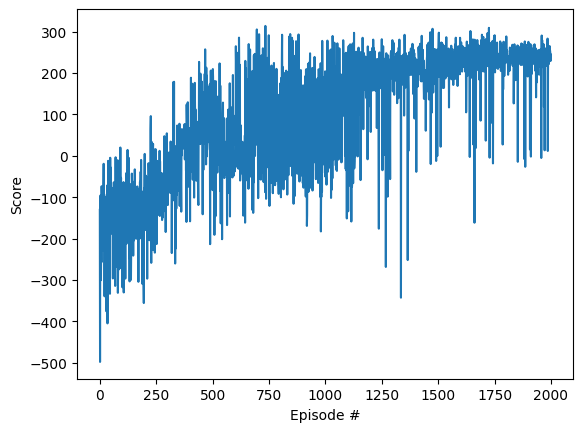

Performance finale (moyenne sur les 100 derniers épisodes): 226.44


In [13]:
import gymnasium as gym
import numpy as np
import torch
import utils # Assurez-vous que votre fichier utils.py est importé et accessible

# --- Hyperparamètres pour l'entraînement ---

# Nombre d'épisodes d'entraînement
NB_EPISODES = 2000
# Valeur de départ pour epsilon (exploration maximale)
EPS_START = 1.0
# Valeur minimale pour epsilon (exploration minimale)
EPS_END = 0.01
# Taux de décroissance d'epsilon (multiplicatif)
EPS_DECAY = 0.997

# --- Hyperparamètres pour l'AgentDQN ---

# Facteur d'actualisation des récompenses futures
GAMMA = 0.99
# Taux d'apprentissage pour l'optimiseur Adam
LR = 3e-4
# Taille maximale du replay buffer
BUFFER_SIZE = 100000
# Taille du minibatch pour chaque phase d'apprentissage
BATCH_SIZE = 64
# Fréquence de mise à jour du réseau (tous les 4 pas)
UPDATE_EVERY = 4

# --- Initialisation de l'environnement et de l'agent ---

# Création de l'environnement LunarLander.
# Note : j'utilise 'v2' car le message d'erreur précédent indiquait que 'v3' n'existait pas.
# Si 'v3' fonctionne pour vous, vous pouvez le laisser.
env = gym.make("LunarLander-v3")

# Récupération des dimensions de l'état et de l'action depuis l'environnement
dim_etat = env.observation_space.shape[0]
dim_action = env.action_space.n

# Création de l'agent avec les hyperparamètres définis
agent = AgentDQN(dim_etat=dim_etat,
                 dim_action=dim_action,
                 gamma=GAMMA,
                 lr=LR,
                 buffer_size=BUFFER_SIZE,
                 batch_size=BATCH_SIZE,
                 update_every=UPDATE_EVERY)

# --- Lancement de l'entraînement ---

print("Début de l'entraînement...")
rewards = dqnalgo(agent=agent,
                  env=env,
                  nb_episodes=NB_EPISODES,
                  eps_start=EPS_START,
                  eps_end=EPS_END,
                  eps_decay=EPS_DECAY)
print("Entraînement terminé.")

# --- Affichage des résultats ---

# Tracé de la somme des récompenses par épisode
utils.plot_sumrwdperepi(rewards)

# Calcul et affichage de la performance finale
mean_last_100_episodes = np.mean(rewards[-100:])
print(f"Performance finale (moyenne sur les 100 derniers épisodes): {mean_last_100_episodes:.2f}")

# Fermeture de l'environnement
env.close()

> <span style="color:green">Faites maintenant une moyenne sur différents seed, avec un apprentissage par seed, et tracer le résultat (somme des récompenses par épisodes) moyenné sur ces seed. Vous utiliserez `init_seed()` et pouvez utiliser `utils.py`.</span> </span> 

In [ ]:
print("Lancement de la visualisation de l'agent entraîné...")
env = gym.make("LunarLander-v3", render_mode="human")
obs, info = env.reset()
terminated = False 
truncated = False
sum_reward = 0
while not terminated and not truncated:
    action = agent.action_egreedy(obs, eps=0.0)
    obs, reward, terminated, truncated, info = env.step(action)
    sum_reward += reward
print(f"\nRécompense obtenue par l'agent entraîné : {sum_reward:.2f}")

Lancement de la visualisation de l'agent entraîné...

Récompense obtenue par l'agent entraîné : 250.81


: 

In [ ]:
nom_fichier = 'agent_dqn_lunarlander_260.pth'
torch.save(agent.network.state_dict(), nom_fichier)
print(f"Agent sauvegardé dans le fichier : {nom_fichier}")

Agent sauvegardé dans le fichier : agent_dqn_lunarlander_260.pth


In [ ]:
import gymnasium as gym
import torch
from agentdqn import AgentDQN

env = gym.make("LunarLander-v3")
dim_etat = env.observation_space.shape[0]
dim_action = env.action_space.n
agent_charge = AgentDQN(dim_etat=dim_etat, dim_action=dim_action)
env.close()

nom_fichier = 'agent_dqn_lunarlander_260.pth'
agent_charge.network.load_state_dict(torch.load(nom_fichier))
print(f"Poids de l'agent chargés depuis : {nom_fichier}")

agent_charge.network.eval()

env_visu = gym.make("LunarLander-v3", render_mode="human")
obs, info = env_visu.reset()
terminated = False
truncated = False
sum_reward = 0

while not terminated and not truncated:
    action = agent_charge.action_egreedy(obs, eps=0.0) # Utiliser l'agent chargé
    obs, reward, terminated, truncated, info = env_visu.step(action)
    sum_reward += reward

print(f"\nRécompense obtenue par l'agent chargé : {sum_reward:.2f}")
env_visu.close()

Poids de l'agent chargés depuis : agent_dqn_lunarlander_260.pth

Récompense obtenue par l'agent chargé : 239.32


# 6. Deep QLearning avec réseau cible

Il se peut que votre agent précédent apprenne des comportements intéressants mais qu’ils soient très instables. On va maintenant ajouter un réseau cible pour l'améliorer.

> <span style="color:green"> Quelle est la cause des instabilités de l'algorithme précédent ? Pourquoi le réseau cible améliore ces instabilités ?</span> 

> <span style="color:blue">Votre réponse: </span>

Le réseau est utilisé à la fois pour calculer des les valeurs actuelles et les valeurs cibles, ce qui crée une boucle de rétroaction, car chaque mise à jour des poids modifie aussi la cible à atteindre. De plus, les valeurs Q peuvent diverger ou osciller, ce qui empêche l'agent d'apprendre de manière stable.

En utilsant un réseau cible, on sépare les calculs des valeurs actuelles et des valeurs cibles. Le réseau cible est mis à jour moins fréquemment, ce qui réduit la corrélation entre les deux et stabilise l'apprentissage.

L'algorithme DQN (avec réseau cible) est donné ci-dessous:

<img src='img/DQNcible.png'  width=500px>


Le réseau cible sera mis à jour toutes les N étapes d'apprentissage (500 par exemple si $t=4$) en recopiant entièrement le réseau de neurone original dans le duplicat.

Pour copier des poids d'un réseau de neurone vers un autre, la méthode `copy_` peut être appelée sur les paramètres:

`for param_duplicat, param_source in zip(model_duplicat.parameters(), model_source.parameters()):`
           
`param_duplicat.data.copy_(param_source.data)`

> <span style="color:green"> Compléter la classe `AgentDQNCible` pour implémenter un agent apprenant avec DQN (deep QLearning et *target network*).</span> 






> <span style="color:green">Utiliser cet agent **dans l'algorithme dqnalgo précédent**. Vous proposerez un tracé de la somme des récompenses obtenues par épisode sur plusieurs seed.</span> 

In [ ]:
from agentdqncible import AgentDQNCible

In [ ]:
# TODO

# 6. Sauvegarde d'un agent

> <span style="color:green"> Sauvegarder un agent qui a correctement appris dans un fichier 'monAgentDQN.pth'. Vous préciserez ci-dessous les hyperparamètres utilisés pour cet agent. </span> 



> <span style="color:blue">Hyperparamètres de l'agent: </span>

In [ ]:
#Exemple de code pour sauvegarde d'un réseau
#savedfile = 'checkpoint.pth'
#torch.save(agent.network.state_dict(), savedfile)

#Exemple de code pour chargement d'un reseau sauvegarde
#state_dict = torch.load(savedfile)
#agent.network.load_state_dict(state_dict)

> <span style="color:green"> Proposer un code ci-dessous pour visualiser un épisode de cet agent en mode glouton. </span> 


In [ ]:
env = gym.make("LunarLander-v3", render_mode="human")
#TODO 

> <span style="color:green"> Si vous avez testé différents hyperparamètres, vous pouvez le préciser ci-dessous. </span> 

> <span style="color:blue">Hyperparamètres testés: </span>